In [257]:
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3
from meteostat import Stations, Daily
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import os
from tqdm import tqdm
import pytz
from datetime import datetime

In [171]:
def display_errors(y_true, y_pred, return_vals=False):
    mse = mean_squared_error(y_true, y_pred)
    print(f"MSE: {round(mse, 3)}")
    rmse = mse ** 0.5
    print(f"RMSE: {round(rmse, 3)}")
    mae = mean_absolute_error(y_true, y_pred)
    print(f"MAE: {round(mae, 3)}")
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"MAPE: {round(mape, 3)}")
    r2 = r2_score(y_true, y_pred)
    print(f"R2: {round(r2, 3)}")

    if return_vals:
        return [mse, rmse, mae, mape, r2]

In [5]:
weather_station_raw = pd.read_csv('StormVistaData/all-stations_northamerica.csv')

In [15]:
stations_id = weather_station_raw['station'].unique()

In [16]:
stations = Stations()
stations = stations.nearby(32.63, -114.62) # arbitrary starting location

In [17]:
stations = stations.fetch()

In [37]:
display(stations)

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
72280,Yuma / Yuma International,US,AZ,72280,KYUM,32.6500,-114.6000,65.0,America/Phoenix,1942-01-16,2007-01-05,1942-11-02,2006-12-25,1942-01-01,1995-01-01,2.907353e+03
KNYL0,Yuma / Desert Royal Mobile Park,US,AZ,<NA>,KNYL,32.6566,-114.6060,65.0,America/Phoenix,1988-01-01,2023-07-10,1988-01-01,2022-04-24,1988-01-01,2020-01-01,3.235241e+03
CDCYH,Yuma Auxiliary Airfield,US,AZ,<NA>,KNOZ,32.5000,-114.4500,105.0,America/Phoenix,2022-04-23,2023-07-05,2022-04-24,2022-04-26,NaT,NaT,2.151186e+04
KLGF0,Yuma / Laguna,US,AZ,<NA>,KLGF,32.8600,-114.3967,132.0,America/Phoenix,2020-01-14,2023-07-09,2020-01-15,2022-04-24,NaT,NaT,3.301838e+04
76005,Mexicali / Islas Agrarias Grupo B,MX,BCN,76005,MMML,32.6306,-115.2415,22.0,America/Tijuana,1990-03-14,2023-07-10,2020-03-10,2020-03-12,NaT,NaT,5.820016e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61984,Saint-Pierre,RE,<NA>,61984,FMEP,-21.3333,55.4833,52.0,Indian/Reunion,1973-01-02,2023-07-10,2013-03-10,2022-04-25,2015-01-01,2022-01-01,1.842337e+07
61995,Vacoas Mauritius,MU,PW,61995,<NA>,-20.3000,57.5000,423.0,Indian/Mauritius,NaT,NaT,1961-01-01,2023-07-02,1961-01-01,2021-01-01,1.843690e+07
61990,Plaisance Mauritius,MU,GP,61990,FIMP,-20.4333,57.6667,55.0,Indian/Mauritius,1949-02-01,2023-07-10,1951-01-01,2023-07-02,1951-01-01,2021-01-01,1.845814e+07


In [38]:
features = ['icao', 'latitude', 'longitude','elevation' ,'name', 'region', 'timezone']
station_df = pd.DataFrame(columns=features)

for station in stations_id:
    temp = stations[stations['icao'] == station]
    station_df = pd.concat([station_df, temp[features]])

In [52]:
display(station_df)

,icao,latitude,longitude,elevation,name,region,timezone
72529,KROC,43.1167,-77.6833,170.0,Greater Rochester International,NY,America/New_York
TMT7J,KDDH,42.8935,-73.2486,252.0,Bennington Morse State Airport,VT,America/New_York
KITR0,KITR,39.2425,-102.2854,1286.0,Burlington / West Burlington,CO,America/Denver
KOTM0,KOTM,41.1066,-92.4479,258.0,Ottumwa / Keb (Historical),IA,America/Chicago
72280,KYUM,32.6500,-114.6000,65.0,Yuma / Yuma International,AZ,America/Phoenix
...,...,...,...,...,...,...,...
72616,KBML,44.5833,-71.0167,353.0,Berlin Municipal Airport,NH,America/New_York
72458,KCNK,39.5500,-97.6500,453.0,"Concordia, Blosser Municipal Airport",KS,America/Chicago
72450,KICT,37.6500,-97.1000,406.0,Wichita Mid-Continent Airport,KS,America/Chicago
74756,KGNV,29.6901,-82.2718,46.0,Gainesville / Brittany Estates Mobile Home Park,FL,America/New_York


In [185]:
id = 'CYYC'
d = station_df.loc[station_df['icao'] == id]
display(d)

,icao,latitude,longitude,elevation,name,region,timezone
71877,CYYC,51.12,-114.01,1099.0,Calgary International Airport,AB,America/Edmonton


Text(0.5, 1.0, 'Ineichen, climatological turbidity(America/Edmonton)')

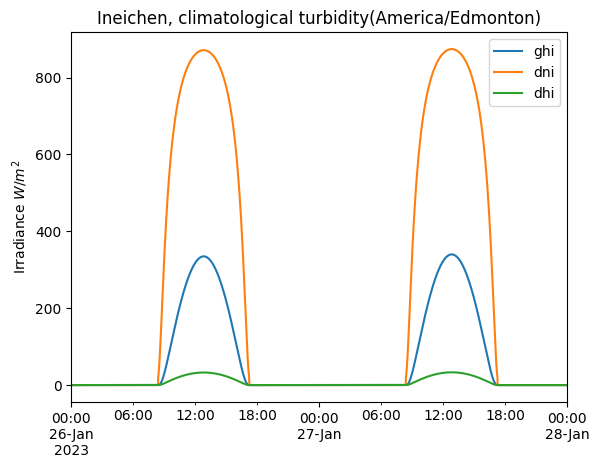

In [187]:
tus = Location(d['latitude'][0], d['longitude'][0], d['timezone'][0], d['elevation'][0])

times = pd.date_range(start='2023-01-26', end='2023-01-28', freq='1min', tz=tus.tz)

cs = tus.get_clearsky(times)  # ineichen with climatology table by default

cs.plot();
plt.ylabel('Irradiance $W/m^2$');
plt.title(f'Ineichen, climatological turbidity({d["timezone"][0]})')

<Figure size 640x480 with 0 Axes>

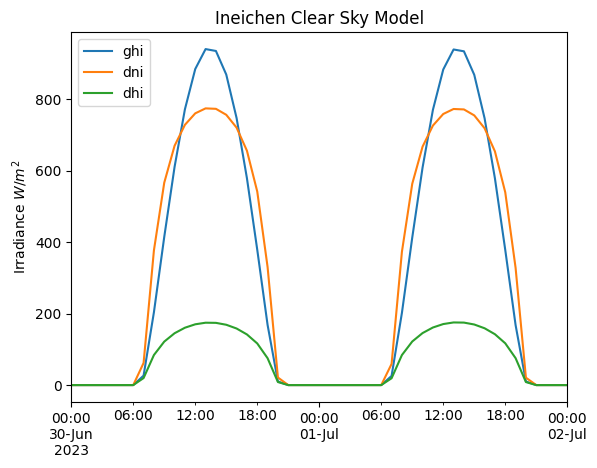

In [133]:
latitude, longitude, tz, altitude, name = d['latitude'][0], d['longitude'][0], d['timezone'][0], d['elevation'][0], id

times = pd.date_range(start='2023-06-30', end='2023-07-02', freq='H', tz=tz)

solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)

apparent_zenith = solpos['apparent_zenith']

airmass = pvlib.atmosphere.get_relative_airmass(apparent_zenith)

pressure = pvlib.atmosphere.alt2pres(altitude)

airmass = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)

linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)

dni_extra = pvlib.irradiance.get_extra_radiation(times)

# an input is a pandas Series, so solis is a DataFrame
ineichen = clearsky.ineichen(apparent_zenith, airmass, linke_turbidity, altitude, dni_extra)

plt.figure();

ax = ineichen.plot()

ax.set_ylabel('Irradiance $W/m^2$');

ax.set_title('Ineichen Clear Sky Model');

ax.legend(loc=2);

In [134]:
data = pd.read_csv('StormVistaData/all-stations_northamerica.csv')

In [135]:
kroc = data[data['station'] == id]
kroc.index = kroc['fhr']

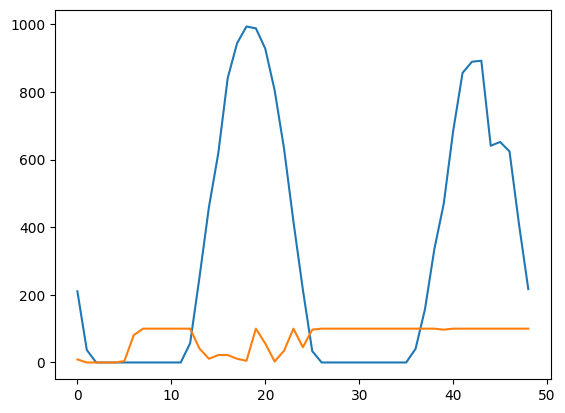

In [136]:
plt.plot(kroc['solar'])
plt.plot(kroc['cloudtotal'])

In [144]:
kroc['solar'][5:].values

array([  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  56.8, 252.4,
       458.9, 618.7, 840.7, 944. , 993.5, 988. , 928. , 804.4, 632. ,
       416.3, 215.6,  33.6,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
         0. ,   0. ,   0. ,   0. ,  40.5, 157.2, 335.3, 469.5, 684. ,
       856.2, 889.2, 892.2, 640.8, 652. , 624.1, 410.8, 216.9])

In [146]:
ineichen['ghi'].values

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  26.45852298,
       203.70562183, 414.53279891, 610.57956949, 771.54024534,
       884.17860497, 939.91332324, 934.62119946, 868.68553482,
       746.99344465, 578.88655749, 378.50924963, 168.27137018,
        10.06431244,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,  25.58602998,
       202.00840776, 412.74699085, 608.8879181 , 770.01724895,
       882.85683981, 938.79969994, 933.70340162, 867.9367662 ,
       746.37746532, 578.36516894, 378.05614102, 167.90925005,
         9.98227209,   0.        ,   0.        ,   0.        ,
         0.        ])

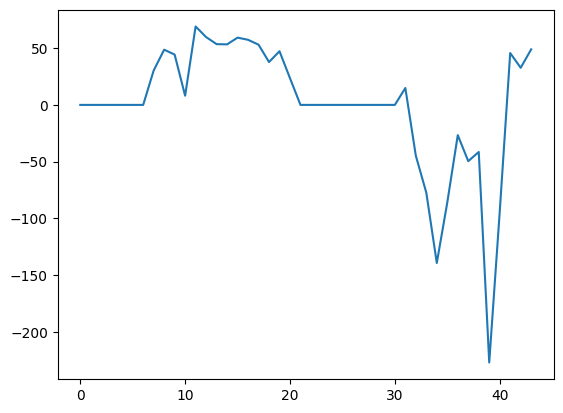

In [151]:
plt.plot(kroc['solar'][5:].values - ineichen['ghi'][:44].values)

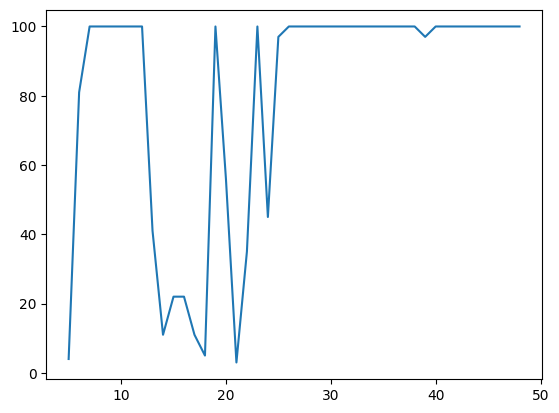

In [154]:
plt.plot(kroc['cloudtotal'][5:])

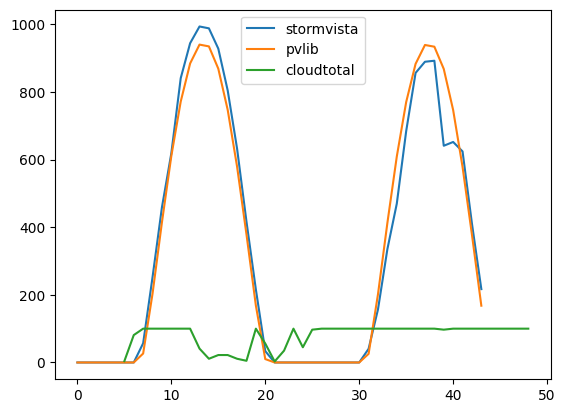

In [157]:
plt.plot(kroc['solar'][5:].values, label='stormvista')
plt.plot(ineichen['ghi'][:44].values, label='pvlib')
plt.plot(kroc['cloudtotal'][5:], label='cloudtotal')
plt.legend()

In [160]:
forecasting_data = weather_station_raw[['cloudtotal', 'fhr', 'solar']]


In [166]:
label = 'solar'
X = forecasting_data.drop(label, axis=1)
y = forecasting_data[label]

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [168]:
model = LinearRegression()
model.fit(train_X, train_y)

LinearRegression()

In [169]:
preds = model.predict(test_X)

In [172]:
display_errors(test_y, preds)

MSE: 99916.932
RMSE: 316.096
MAE: 268.007
MAPE: 4.4097531703029574e+17
R2: 0.139


In [173]:
preds

array([350.86689595, 277.21157975, 364.52739784, ..., 530.61201275,
       340.9759227 , 283.3336065 ])

In [175]:
train_y

15820     915.2
23442    1007.0
6035        0.0
10185     126.2
19240       0.0
          ...  
21575     709.7
5390      212.5
860         0.0
15795     951.0
23654      22.8
Name: solar, Length: 20423, dtype: float64

In [177]:
from autogluon.tabular import TabularDataset, TabularPredictor
shuffled_data = forecasting_data.sample(frac=1, random_state=42)
train_len = 0.85
train_data = TabularDataset(shuffled_data[:int(len(shuffled_data)*train_len)])
test_data = TabularDataset(shuffled_data[int(len(shuffled_data)*train_len):])

In [178]:
y_test = test_data[label]
test_data_nolabel = test_data.drop(label, axis=1)

In [179]:
predictor = TabularPredictor(label=label).fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20230711_213326/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230711_213326/"
AutoGluon Version:  0.7.0
Python Version:     3.10.9
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 22.5.0: Thu Jun  8 22:22:19 PDT 2023; root:xnu-8796.121.3~7/RELEASE_ARM64_T8103
Train Data Rows:    21699
Train Data Columns: 2
Label Column: solar
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1088.0, 0.0, 290.84992, 340.68927)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeature

In [180]:
fi = predictor.feature_importance(test_data, silent=True)
display(fi.head(10))

,importance,stddev,p_value,n,p99_high,p99_low
fhr,327.091568,4.792387,5.528243e-09,5,336.959160,317.223977
cloudtotal,63.367280,3.289800,8.686396e-07,5,70.141023,56.593537


In [181]:
y_pred = predictor.predict(test_data_nolabel)
display_errors(y_test, y_pred)

MSE: 16579.651
RMSE: 128.762
MAE: 80.253
MAPE: 2.0640407996476036e+16
R2: 0.858


In [184]:
y_pred.describe()

count    3830.000000
mean      292.986877
std       314.679169
min       -14.679995
25%         2.664277
50%       156.505478
75%       560.081482
max       999.052307
Name: solar, dtype: float64

In [2]:
data = pd.read_pickle('StormVistaData/hourly_power.pickle')

In [4]:
display(data)

{'natural_gas':                       value
 Date                       
 2018-07-01 05:00:00   66791
 2018-07-01 06:00:00   95197
 2018-07-01 07:00:00   91741
 2018-07-01 08:00:00  103817
 2018-07-01 09:00:00   99727
 ...                     ...
 2023-07-12 00:00:00  311253
 2023-07-12 01:00:00  309032
 2023-07-12 02:00:00  296204
 2023-07-12 03:00:00  274463
 2023-07-12 04:00:00  246511
 
 [44088 rows x 1 columns],
 'nuclear':                      value
 Date                      
 2018-07-01 05:00:00  58363
 2018-07-01 06:00:00  75818
 2018-07-01 07:00:00  75650
 2018-07-01 08:00:00  81700
 2018-07-01 09:00:00  81733
 ...                    ...
 2023-07-12 00:00:00  94510
 2023-07-12 01:00:00  94713
 2023-07-12 02:00:00  94469
 2023-07-12 03:00:00  94496
 2023-07-12 04:00:00  94509
 
 [44088 rows x 1 columns],
 'other':                      value
 Date                      
 2018-07-01 05:00:00   5226
 2018-07-01 06:00:00   6460
 2018-07-01 07:00:00   5983
 2018-07-01 08:00:00   703

# get weighted soalr production by state
solar data for nam-hires starts 20221013.12 [file 1088]

In [792]:
import requests

In [793]:
station_info = pd.read_csv('StormVistaData/station_df.csv')
station_region = station_info[['icao', 'region']].rename(columns={'icao': 'station'})

In [794]:
api_key = 'cH2rbrRMzTedExBIE6okFZvmLQCkpjmys1rjwiVY'
master_df = pd.DataFrame()
for i in range(2):
    url = f'https://api.eia.gov/v2/electricity/operating-generator-capacity/data/?api_key={api_key}&\
    frequency=monthly&data[0]=net-summer-capacity-mw&data[1]=net-winter-capacity-mw&facets[energy_source_code][]=SUN&start=2023-04&sort[0][column]=period&sort[0][direction]=desc&offset={i*5000}&length=6000'
    data = requests.get(url).json()
    df = pd.DataFrame(data['response']['data'])
    df = df[['period', 'stateid', 'net-summer-capacity-mw', 'net-winter-capacity-mw']]
    master_df = master_df.append(df)

In [795]:
prod_capicity = master_df.groupby('stateid').sum()

In [796]:
total_summer = prod_capicity['net-summer-capacity-mw'].sum()

In [797]:
prod_capicity['net-summer-capacity-mw'] = prod_capicity['net-summer-capacity-mw'].astype(float)
prod_capicity['percent_of_production'] = prod_capicity['net-summer-capacity-mw']/total_summer

In [798]:
display(prod_capicity.sort_values(by='percent_of_production', ascending=False))

,net-summer-capacity-mw,net-winter-capacity-mw,percent_of_production
stateid,,,
CA,17653.8,17383.5,0.232130
TX,11473.5,11462.7,0.150865
FL,7486.0,7485.1,0.098434
NC,6180.4,6138.2,0.081266
GA,3648.1,3648.7,0.047969
NV,3413.5,3348.3,0.044884
AZ,2998.6,2984.9,0.039429
VA,2854.9,2787.6,0.037539
UT,1613.3,1612.4,0.021213


In [799]:
region_pop = prod_capicity.reset_index().rename(columns={'stateid': 'region'})[['region', 'percent_of_production']]

In [800]:
SolarDataPath = "/Users/nickgault/Downloads/SolarData"
files = os.listdir(SolarDataPath)

In [865]:
#solar_df = pd.DataFrame(columns=['date', 'total_solar'])
solar_df = pd.DataFrame()

for file in tqdm(sorted(files, reverse=True)[:1088]): #1089
    prod_df = pd.read_csv(f'{SolarDataPath}/{file}')
    date = file.split('.')[1]
    time = file.split('.')[2]
    date_time = f'{date} {time}:00:00'
    dt = pd.to_datetime(date_time, format='%Y%m%d %H:%M:%S')

    station_solar = prod_df.groupby('station').sum(numeric_only=True)['solar'].to_frame()
    station_solar = station_solar.reset_index()
    station_solar_region = pd.merge(station_solar, station_region, on='station')
    region_solar = station_solar_region.groupby('region').sum(numeric_only=True)
    merged = pd.merge(region_pop, region_solar, on='region')
    merged['total_solar'] = merged['percent_of_production'] * merged['solar']
    total_solar = merged['total_solar'].sum(numeric_only=True)
    solar_df = pd.concat([solar_df, pd.DataFrame({'date': [dt], 'total_solar': [total_solar]})])

100%|██████████| 1088/1088 [00:43<00:00, 25.29it/s]


In [866]:
solar_df

,date,total_solar
0,2023-07-12 12:00:00,585379.614879
0,2023-07-12 06:00:00,455264.190087
0,2023-07-12 00:00:00,425483.700647
0,2023-07-11 18:00:00,562145.170998
0,2023-07-11 12:00:00,577851.321466
...,...,...
0,2022-10-14 18:00:00,297503.504899
0,2022-10-14 12:00:00,319010.369099
0,2022-10-14 06:00:00,256323.040950
0,2022-10-14 00:00:00,236629.745186


In [870]:
solar_df.set_index('date', inplace=True)

In [871]:
solar_df['total_solar']

date
2023-07-12 12:00:00    585379.614879
2023-07-12 06:00:00    455264.190087
2023-07-12 00:00:00    425483.700647
2023-07-11 18:00:00    562145.170998
2023-07-11 12:00:00    577851.321466
                           ...      
2022-10-14 18:00:00    297503.504899
2022-10-14 12:00:00    319010.369099
2022-10-14 06:00:00    256323.040950
2022-10-14 00:00:00    236629.745186
2022-10-13 18:00:00    328778.673045
Name: total_solar, Length: 1088, dtype: float64

<AxesSubplot: xlabel='date'>

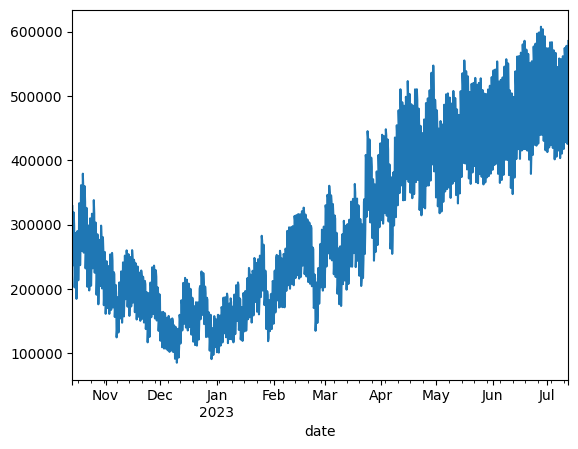

In [872]:
solar_df['total_solar'].plot()

# predicting solar production for dates before 20221013.12

In [873]:
def get_ineichen(d, latitude, longitude, tz, altitude):

    times = pd.date_range(start=f'{d.year}-{d.month}-{d.day}', end=f'{d.year}-{d.month}-{d.day+3}', freq='H', tz=tz)

    solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
    apparent_zenith = solpos['apparent_zenith']
    airmass = pvlib.atmosphere.get_relative_airmass(apparent_zenith)
    pressure = pvlib.atmosphere.alt2pres(altitude)
    airmass = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)
    dni_extra = pvlib.irradiance.get_extra_radiation(times)

    # an input is a pandas Series, so solis is a DataFrame
    ineichen = clearsky.ineichen(apparent_zenith, airmass, linke_turbidity, altitude, dni_extra)

    return ineichen

In [883]:
# try only using citys
citys = ['72278', '72295', '72565', '72508', 'H3GG0',
         '72405', '72206', 'KFTY0', '72681', '72530', '72438',
         '72546', '72451', '72435', '74754', '72606', '72406',
         '72509', '72635', '72644', '72235', '72446', '72773']
master_merged = pd.DataFrame()
#for file in tqdm(sorted(files, reverse=True)[:200]): #1089

for i in range(10):
    prod_df = pd.read_csv(f'{SolarDataPath}/{sorted(files, reverse=True)[i]}')
    time = int(file.split('.')[2])
    date = file.split('.')[1]
    prod_df['hour'] = (prod_df['fhr'] + time) % 24
    prod_df['day_offset'] = prod_df['fhr'] // 24

    stations = prod_df['station'].unique()
    si = station_info[['icao', 'latitude', 'longitude', 'elevation', 'timezone', 'region']].rename(
        columns={'icao': 'station'})

    prod_df['date'] = int(date) + prod_df['day_offset']
    prod_df['date'] = pd.to_datetime(prod_df['date'], format='%Y%m%d')
    prod_df['date'] = prod_df['date'] + pd.to_timedelta(prod_df['hour'], unit='h')
    prod_df['month'] = prod_df['date'].dt.month

    prod_df = prod_df[['station', 'hour', 'cloudtotal', 'month', 'date', 'solar']]

    temp_merged = pd.DataFrame()
    for station in stations[:1]:
        temp_prod_df = prod_df[prod_df['station'] == station]
        m = si[si['station'] == stations[0]].iloc[0]
        d = pd.to_datetime(date, format='%Y%m%d')
        latitude, longitude, tz, altitude, name = m['latitude'], m['longitude'], m['timezone'], m['elevation'],  m['region']
        ineichen = get_ineichen(d, latitude, longitude, tz, altitude)
        ineichen.index = ineichen.index.tz_convert(None)
        ineichen['date'] = ineichen.index
        merged = pd.merge(temp_prod_df, ineichen, on='date')

        target_tz = pytz.timezone(tz)
        now = datetime.now(target_tz)
        offset = now.utcoffset().total_seconds() // 3600
        merged['solar'] = merged['solar'].shift(int(offset))

        temp_merged = pd.concat([temp_merged, merged], axis=0).drop_duplicates()

    #master_merged = master_merged.append(temp_merged)
    master_merged = pd.concat([master_merged, temp_merged], axis=0).drop_duplicates()


In [884]:
master_merged[master_merged['station'] == 'KROC'][:50]

,station,hour,cloudtotal,month,date,solar,ghi,dni,dhi
0,KROC,18,18.0,10,2022-10-13 18:00:00,614.1,583.726376,824.524775,87.917706
1,KROC,19,23.0,10,2022-10-13 19:00:00,740.0,495.962004,787.709312,81.134191
2,KROC,20,99.0,10,2022-10-13 20:00:00,470.0,360.012832,709.564497,69.311973
3,KROC,21,100.0,10,2022-10-13 21:00:00,380.2,189.980016,541.444286,49.937639
4,KROC,22,93.0,10,2022-10-13 22:00:00,292.0,26.231952,146.381621,13.788444
5,KROC,23,31.0,10,2022-10-13 23:00:00,19.0,0.000000,0.000000,0.000000
6,KROC,4,11.0,10,2022-10-13 04:00:00,9.0,0.000000,0.000000,0.000000
7,KROC,5,18.0,10,2022-10-13 05:00:00,6.0,0.000000,0.000000,0.000000
8,KROC,6,82.0,10,2022-10-13 06:00:00,0.0,0.000000,0.000000,0.000000
9,KROC,7,59.0,10,2022-10-13 07:00:00,0.0,0.000000,0.000000,0.000000


In [885]:
master_merged[['station', 'date', 'hour', 'ghi','solar']]

,station,date,hour,ghi,solar
0,KROC,2022-10-13 18:00:00,18,583.726376,614.1
1,KROC,2022-10-13 19:00:00,19,495.962004,740.0
2,KROC,2022-10-13 20:00:00,20,360.012832,470.0
3,KROC,2022-10-13 21:00:00,21,189.980016,380.2
4,KROC,2022-10-13 22:00:00,22,26.231952,292.0
...,...,...,...,...,...
52,KROC,2022-10-15 02:00:00,2,0.000000,310.0
53,KROC,2022-10-15 03:00:00,3,0.000000,NaN
54,KROC,2022-10-15 04:00:00,4,0.000000,NaN
55,KROC,2022-10-15 05:00:00,5,0.000000,NaN


In [609]:
time = int(file.split('.')[2])
date = file.split('.')[1]
prod_df['hour'] = (prod_df['fhr'] + time) % 24
prod_df['day_offset'] = prod_df['fhr'] // 24

In [611]:
prod_df = prod_df[['station', 'hour', 'cloudtotal', 'solar', 'day_offset']]

In [612]:
stations = prod_df['station'].unique()

In [613]:
si = station_info[['icao', 'latitude', 'longitude', 'elevation', 'timezone', 'region']].rename(columns={'icao': 'station'})

In [614]:
si

,station,latitude,longitude,elevation,timezone,region
0,KROC,43.1167,-77.6833,170.0,America/New_York,NY
1,KDDH,42.8935,-73.2486,252.0,America/New_York,VT
2,KITR,39.2425,-102.2854,1286.0,America/Denver,CO
3,KOTM,41.1066,-92.4479,258.0,America/Chicago,IA
4,KYUM,32.6500,-114.6000,65.0,America/Phoenix,AZ
...,...,...,...,...,...,...
508,KBML,44.5833,-71.0167,353.0,America/New_York,NH
509,KCNK,39.5500,-97.6500,453.0,America/Chicago,KS
510,KICT,37.6500,-97.1000,406.0,America/Chicago,KS
511,KGNV,29.6901,-82.2718,46.0,America/New_York,FL


In [615]:
m = si[si['station'] == stations[0]].iloc[0]

In [616]:
d = pd.to_datetime(date, format='%Y%m%d')

In [618]:
ineichen['ghi']

2023-07-10 00:00:00-04:00      0.000000
2023-07-10 01:00:00-04:00      0.000000
2023-07-10 02:00:00-04:00      0.000000
2023-07-10 03:00:00-04:00      0.000000
2023-07-10 04:00:00-04:00      0.000000
2023-07-10 05:00:00-04:00      0.000000
2023-07-10 06:00:00-04:00      3.471373
2023-07-10 07:00:00-04:00    120.282135
2023-07-10 08:00:00-04:00    301.655923
2023-07-10 09:00:00-04:00    485.999364
2023-07-10 10:00:00-04:00    651.548042
2023-07-10 11:00:00-04:00    784.278212
2023-07-10 12:00:00-04:00    874.060447
2023-07-10 13:00:00-04:00    914.301330
2023-07-10 14:00:00-04:00    902.085364
2023-07-10 15:00:00-04:00    838.283980
2023-07-10 16:00:00-04:00    727.521907
2023-07-10 17:00:00-04:00    578.028199
2023-07-10 18:00:00-04:00    401.608682
2023-07-10 19:00:00-04:00    214.873035
2023-07-10 20:00:00-04:00     49.624007
2023-07-10 21:00:00-04:00      0.000000
2023-07-10 22:00:00-04:00      0.000000
2023-07-10 23:00:00-04:00      0.000000
2023-07-11 00:00:00-04:00      0.000000


In [619]:
prod_df['date'] = int(date) + prod_df['day_offset']

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [620]:
prod_df['date'] = pd.to_datetime(prod_df['date'], format='%Y%m%d')

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [621]:
prod_df['date'] = prod_df['date'] + pd.to_timedelta(prod_df['hour'], unit='h')

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [625]:
prod_df

,station,hour,cloudtotal,solar,day_offset,date,month
0,KROC,6,98.0,0.0,0,2023-07-10 06:00:00,7
1,KROC,7,100.0,0.0,0,2023-07-10 07:00:00,7
2,KROC,8,100.0,0.0,0,2023-07-10 08:00:00,7
3,KROC,9,100.0,0.0,0,2023-07-10 09:00:00,7
4,KROC,10,100.0,0.0,0,2023-07-10 10:00:00,7
...,...,...,...,...,...,...,...
31776,CXMW,14,45.0,33.0,2,2023-07-12 14:00:00,7
31777,CXMW,15,28.0,92.0,2,2023-07-12 15:00:00,7
31778,CXMW,16,20.0,507.9,2,2023-07-12 16:00:00,7
31779,CXMW,17,20.0,583.7,2,2023-07-12 17:00:00,7


In [626]:
prod_df.set_index('date', inplace=True)

In [548]:
prod_df['month'] = prod_df.index.month

In [656]:
ineichen

,ghi,dni,dhi
2023-07-10 00:00:00-04:00,0.000000,0.000000,0.000000
2023-07-10 01:00:00-04:00,0.000000,0.000000,0.000000
2023-07-10 02:00:00-04:00,0.000000,0.000000,0.000000
2023-07-10 03:00:00-04:00,0.000000,0.000000,0.000000
2023-07-10 04:00:00-04:00,0.000000,0.000000,0.000000
...,...,...,...
2023-07-12 20:00:00-04:00,47.635007,169.269468,25.816511
2023-07-12 21:00:00-04:00,0.000000,0.000000,0.000000
2023-07-12 22:00:00-04:00,0.000000,0.000000,0.000000
2023-07-12 23:00:00-04:00,0.000000,0.000000,0.000000
